In [1]:
!mkdir -p /tmp/pip/cache/
!cp ../input/nfl-trans-filter/scikit_learn-0.22.2.post1* /tmp/pip/cache/
!cp ../input/nfl-offline-libs/ensemble* /tmp/pip/cache/
!ls /tmp/pip/cache/

!pip install --ignore-installed --no-dependencies --no-index --find-links /tmp/pip/cache/ scikit_learn > /dev/null
!pip install --no-index --find-links /tmp/pip/cache/ ensemble-boxes > /dev/null

ensemble_boxes-1.0.4-py3-none-any.whl
scikit_learn-0.22.2.post1-cp37-cp37m-manylinux1_x86_64.whl


In [2]:
import sys

import pandas as pd
import numpy as np
import random, os, io

import torch
from torch.utils.data import Dataset,DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import cv2
from tqdm.auto import tqdm

from glob import glob

from sklearn.preprocessing import StandardScaler

import pickle

# identify frames with impact based on tracking data

In [3]:
tracking = pd.read_csv('../input/nfl-impact-detection/test_player_tracking.csv')
tracking['home'] = tracking['player'].apply(lambda s : s[0] == 'H')
tracking = tracking.sort_values(['gameKey', 'playID', 'time', 'player'])

In [4]:
ss = tracking.sort_values(['gameKey', 'playID', 'time', 'player']).groupby(['gameKey', 'playID', 'time']).size()
ss = ss.cumsum()

ssx = np.zeros(len(ss) + 1, 'int')
ssx[1:] = ss
ssx

dist_data = tracking[['x', 'y']].values
player_data = tracking[['player', 'home']].values

tracking['shorter_opp'] = np.NaN

In [5]:
for index in tqdm(range(len(ssx)-1)):
    locs = dist_data[ssx[index]:ssx[index + 1], :]

    d=locs[:,None,:]-locs
    r = np.sqrt(np.einsum('ijk,ijk->ij',d,d))

    for i, (p, h) in enumerate(player_data[ssx[index]:ssx[index + 1], :]):
        mask = player_data[ssx[index]:ssx[index + 1], 1]
        dist = r[i]
        if h:
            dist[mask.astype(np.bool)] = 200
        else:
            dist[np.invert(mask.astype(np.bool))] = 200

    tracking.iloc[ssx[index]:ssx[index + 1], -1] = player_data[ssx[index]:ssx[index + 1], 0][r.argmin(axis=1)]

In [6]:
# retrieve opponent informations
tracking = tracking.join(tracking.set_index(['gameKey', 'playID', 'time', 'player']), on=['gameKey', 'playID', 'time', 'shorter_opp'], rsuffix='_opp')

# add some global metrics
tracking['mean_a'] = tracking.groupby(['gameKey', 'playID', 'time'])['a'].transform('mean')
tracking['mean_s'] = tracking.groupby(['gameKey', 'playID', 'time'])['s'].transform('mean')
tracking['mean_o'] = tracking.groupby(['gameKey', 'playID', 'time'])['o'].transform('mean')
tracking['mean_dir'] = tracking.groupby(['gameKey', 'playID', 'time'])['dir'].transform('mean')
tracking['std_a'] = tracking.groupby(['gameKey', 'playID', 'time'])['a'].transform('std')
tracking['std_s'] = tracking.groupby(['gameKey', 'playID', 'time'])['s'].transform('std')
tracking['std_o'] = tracking.groupby(['gameKey', 'playID', 'time'])['o'].transform('std')
tracking['std_dir'] = tracking.groupby(['gameKey', 'playID', 'time'])['dir'].transform('std')
tracking['dist_play'] = ((tracking['x'] - tracking['x_opp'])**2 + (tracking['y'] - tracking['y_opp'])**2)**.5

In [7]:
tracking

,gameKey,playID,player,time,x,y,s,a,dis,o,...,shorter_opp_opp,mean_a,mean_s,mean_o,mean_dir,std_a,std_s,std_o,std_dir,dist_play
4104,57906,718,H14,2019-09-08T17:29:28.700Z,9.81,29.04,0.02,0.02,0.04,33.98,...,H55,0.780,1.486818,179.700000,132.890909,0.790618,1.404392,98.733389,99.957723,5.969531
1824,57906,718,H26,2019-09-08T17:29:28.700Z,8.03,31.17,1.20,1.30,0.12,201.93,...,H55,0.780,1.486818,179.700000,132.890909,0.790618,1.404392,98.733389,99.957723,7.738579
4560,57906,718,H47,2019-09-08T17:29:28.700Z,8.69,30.06,0.77,3.58,0.06,102.10,...,H55,0.780,1.486818,179.700000,132.890909,0.790618,1.404392,98.733389,99.957723,7.000007
0,57906,718,H55,2019-09-08T17:29:28.700Z,11.92,30.08,2.15,0.80,0.22,112.10,...,H55,0.780,1.486818,179.700000,132.890909,0.790618,1.404392,98.733389,99.957723,3.770013
1368,57906,718,H67,2019-09-08T17:29:28.700Z,11.69,28.94,2.37,0.91,0.24,122.74,...,H55,0.780,1.486818,179.700000,132.890909,0.790618,1.404392,98.733389,99.957723,4.156549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18064,58102,2798,V75,2019-12-08T23:10:20.500Z,61.89,20.32,2.86,1.40,0.30,136.83,...,V75,2.305,2.979545,165.905909,161.658636,1.408561,1.628252,70.158777,62.878533,3.260061
17548,58102,2798,V76,2019-12-08T23:10:20.500Z,59.66,26.19,1.37,0.54,0.14,102.62,...,V75,2.305,2.979545,165.905909,161.658636,1.408561,1.628252,70.158777,62.878533,5.939983
19268,58102,2798,V78,2019-12-08T23:10:20.500Z,63.54,16.93,1.65,1.91,0.17,144.53,...,V86,2.305,2.979545,165.905909,161.658636,1.408561,1.628252,70.158777,62.878533,2.047926
18752,58102,2798,V81,2019-12-08T23:10:20.500Z,69.71,29.41,4.07,1.81,0.42,174.72,...,V81,2.305,2.979545,165.905909,161.658636,1.408561,1.628252,70.158777,62.878533,4.249471


In [8]:
tracking = tracking.drop_duplicates().sort_values(['gameKey', 'playID', 'player', 'time'])
# add frame ids
tracking = tracking.sort_values(['gameKey', 'playID', 'player', 'time']).reset_index(drop=True)
tracking['frame_id'] = -1
result = []

pd.set_option("mode.chained_assignment", None)
for gameKey, playID, player in tqdm(tracking.groupby(['gameKey', 'playID', 'player']).size().keys()):
    index_ball_snap = tracking[(tracking.gameKey == gameKey) & 
             (tracking.playID == playID) & 
             (tracking.player == player) & 
             (tracking.event == 'ball_snap')].index.values[0]

    lookup = tracking[(tracking.gameKey == gameKey) & 
             (tracking.playID == playID) & 
             (tracking.player == player)]

    for index, row in lookup.iterrows():
        offset = index - index_ball_snap
        if offset >= 0:
            tracking.iloc[index, -1] = 10 + offset * 6

In [9]:
# tells if the closest player is the same one
tracking = tracking.sort_values(['gameKey', 'playID', 'player', 'time']).reset_index(drop=True)
tracking['same_player'] = [int(prev == next) for prev, next in zip(list(tracking.shorter_opp.values) + ['toto'], ['toto'] + list(tracking.shorter_opp.values))][:-1]

tracking['home'] = tracking['home'].astype(int)
tracking['home_opp'] = tracking['home_opp'].astype(int)

In [10]:
import math

tracking['o'] = tracking['o'].apply(math.radians)
tracking['o_opp'] = tracking['o_opp'].apply(math.radians)
tracking['dir'] = tracking['dir'].apply(math.radians)
tracking['dir_opp'] = tracking['dir_opp'].apply(math.radians)

tracking['o_x'] = tracking['o'].apply(math.cos)
tracking['o_y'] = tracking['o'].apply(math.sin)
tracking['o_opp_x'] = tracking['o_opp'].apply(math.cos)
tracking['o_opp_y'] = tracking['o_opp'].apply(math.sin)
tracking['dir_x'] = tracking['dir'].apply(math.cos)
tracking['dir_y'] = tracking['dir'].apply(math.sin)
tracking['dir_opp_x'] = tracking['dir_opp'].apply(math.cos)
tracking['dir_opp_y'] = tracking['dir_opp'].apply(math.sin)

tracking['scalar_o'] = tracking['o_x'] * tracking['o_opp_x'] + tracking['o_y'] * tracking['o_opp_y']
tracking['scalar_dir'] = tracking['dir_x'] * tracking['dir_opp_x'] + tracking['dir_y'] * tracking['dir_opp_y']

tracking['scalar_o_opp'] = tracking['scalar_o'] 
tracking['scalar_dir_opp'] = tracking['scalar_dir']

tracking = tracking.drop(columns=['x', 'y', 'o', 'dir', 'o_x', 'o_y', 'o_opp_x', 'o_opp_y', 
                                      'dir_x', 'dir_y', 'dir_opp_x', 'dir_opp_y', 'mean_o', 'mean_dir'])


In [11]:
'''FEAT1=['s', 'a', 'dis', 'scalar_o', 'scalar_dir']
for f in FEAT1:
    tracking[f+'diff']=np.abs(tracking[f]-tracking[f+'_opp'])
    tracking[f+'plus']=(tracking[f]+tracking[f+'_opp'])
    tracking[f+'fois']=(tracking[f]*tracking[f+'_opp'])
    tracking[f+'div1']=(tracking[f]/(tracking[f+'_opp']+1e-06))
    tracking[f+'div2']=(tracking[f+'_opp']/(tracking[f]+1e-06))
print("compute lags")
def lag_compute(df, cols2group, dict_cols2shift, isprefix=True):
    # Compute lag on PUSHED
    for key in dict_cols2shift.keys():
        assert(type(dict_cols2shift[key]) == list)
        str_past_future = ''
        for ii in dict_cols2shift[key]:
            if ii == 0:
                continue
            if ii > 0:
                if isprefix:
                    str_past_future = '__past'
                df[key + '__' +
                   str(ii) +
                   str_past_future] = df.groupby(cols2group)[key].shift(ii).fillna(0)
            else:
                if isprefix:
                    str_past_future = '__future'
                df[key + '__' +
                   str(ii*-1) +
                   str_past_future] = df.groupby(cols2group)[key].shift(ii).fillna(0)
    return df
intro = ['s', 'a', 'dis', 'scalar_o', 'scalar_dir', 
         's_opp', 'a_opp', 'dis_opp', 'scalar_o_opp', 'scalar_dir_opp',
         'sdiff', 'adiff', 'disdiff', 'scalar_odiff', 'scalar_dirdiff',
         'splus', 'aplus', 'displus', 'scalar_oplus', 'scalar_dirplus',
         'sfois', 'afois', 'disfois', 'scalar_ofois', 'scalar_dirfois',
         'sdiv1', 'adiv1', 'disdiv1', 'scalar_odiv1', 'scalar_dirdiv1',
         'sdiv2', 'adiv2', 'disdiv2', 'scalar_odiv2', 'scalar_dirdiv2',         
         'mean_a', 'mean_s', 'std_a', 'std_s', 'std_dir', 'std_o',
         'dist_play']
col_to_scale=intro.copy()
for c in intro:
    print(c)
    tracking = lag_compute(tracking,['gameKey','playID','player'],{c: list(range(0,5))})
    tracking = lag_compute(tracking,['gameKey','playID','player'],{c: list(range(-4,0))})
    col_to_scale.append(c+'__1__future')
    col_to_scale.append(c+'__2__future')
    col_to_scale.append(c+'__3__future')
    col_to_scale.append(c+'__4__future')
    col_to_scale.append(c+'__1__past')
    col_to_scale.append(c+'__2__past')
    col_to_scale.append(c+'__3__past')
    col_to_scale.append(c+'__4__past')    
    tracking[c+c+'__1__future'+'diff']=np.abs(tracking[c]-tracking[c+'__1__future'])
    col_to_scale.append(c+c+'__1__future'+'diff')
    tracking[c+c+'__2__future'+'diff']=np.abs(tracking[c]-tracking[c+'__2__future'])
    col_to_scale.append(c+c+'__2__future'+'diff')    
    tracking[c+c+'__3__future'+'diff']=np.abs(tracking[c]-tracking[c+'__3__future'])
    col_to_scale.append(c+c+'__3__future'+'diff')    
    tracking[c+c+'__4__future'+'diff']=np.abs(tracking[c]-tracking[c+'__4__future'])
    col_to_scale.append(c+c+'__4__future'+'diff')    
    tracking[c+c+'__1__past'+'diff']=np.abs(tracking[c]-tracking[c+'__1__past'])
    col_to_scale.append(c+c+'__1__past'+'diff')
    tracking[c+c+'__2__past'+'diff']=np.abs(tracking[c]-tracking[c+'__2__past'])
    col_to_scale.append(c+c+'__2__past'+'diff')    
    tracking[c+c+'__3__past'+'diff']=np.abs(tracking[c]-tracking[c+'__3__past'])
    col_to_scale.append(c+c+'__3__past'+'diff')    
    tracking[c+c+'__4__past'+'diff']=np.abs(tracking[c]-tracking[c+'__4__past'])
    col_to_scale.append(c+c+'__4__past'+'diff')    
'''

'FEAT1=[\'s\', \'a\', \'dis\', \'scalar_o\', \'scalar_dir\']\nfor f in FEAT1:\n    tracking[f+\'diff\']=np.abs(tracking[f]-tracking[f+\'_opp\'])\n    tracking[f+\'plus\']=(tracking[f]+tracking[f+\'_opp\'])\n    tracking[f+\'fois\']=(tracking[f]*tracking[f+\'_opp\'])\n    tracking[f+\'div1\']=(tracking[f]/(tracking[f+\'_opp\']+1e-06))\n    tracking[f+\'div2\']=(tracking[f+\'_opp\']/(tracking[f]+1e-06))\nprint("compute lags")\ndef lag_compute(df, cols2group, dict_cols2shift, isprefix=True):\n    # Compute lag on PUSHED\n    for key in dict_cols2shift.keys():\n        assert(type(dict_cols2shift[key]) == list)\n        str_past_future = \'\'\n        for ii in dict_cols2shift[key]:\n            if ii == 0:\n                continue\n            if ii > 0:\n                if isprefix:\n                    str_past_future = \'__past\'\n                df[key + \'__\' +\n                   str(ii) +\n                   str_past_future] = df.groupby(cols2group)[key].shift(ii).fillna(0)\n    

In [12]:
col_to_scale = ['s', 'a', 'dis', 'scalar_o', 'scalar_dir', 
         's_opp', 'a_opp', 'dis_opp', 'scalar_o_opp', 'scalar_dir_opp',
         'mean_a', 'mean_s', 'std_a', 'std_s', 'std_dir', 'std_o',
         'dist_play']

In [13]:
DIM=len(col_to_scale)+1
print(DIM)

tracking = tracking.sort_values(['gameKey',	'playID',	'player', 'time'])
tracking = tracking.reset_index(drop=True)

tracking

18


,gameKey,playID,player,time,s,a,dis,event,home,shorter_opp,...,std_s,std_o,std_dir,dist_play,frame_id,same_player,scalar_o,scalar_dir,scalar_o_opp,scalar_dir_opp
0,57906,718,H14,2019-09-08T17:29:28.700Z,0.02,0.02,0.04,huddle_start_offense,1,V98,...,1.404392,98.733389,99.957723,5.969531,-1,0,-0.484046,-0.228351,-0.484046,-0.228351
1,57906,718,H14,2019-09-08T17:29:28.799Z,0.01,0.02,0.03,NaN,1,V98,...,1.386381,98.715101,100.196803,5.957961,-1,1,-0.518475,0.200565,-0.518475,0.200565
2,57906,718,H14,2019-09-08T17:29:28.900Z,0.01,0.02,0.03,NaN,1,V98,...,1.364641,98.417590,88.982254,5.957961,-1,1,-0.551500,0.498185,-0.551500,0.498185
3,57906,718,H14,2019-09-08T17:29:29.000Z,0.08,1.10,0.03,NaN,1,V98,...,1.337044,97.688900,74.936970,5.959681,-1,1,-0.625243,0.986714,-0.625243,0.986714
4,57906,718,H14,2019-09-08T17:29:29.099Z,0.31,2.42,0.03,NaN,1,V98,...,1.304983,98.210514,74.713471,5.971265,-1,1,-0.627827,0.998639,-0.627827,0.998639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19264,58102,2798,V86,2019-12-08T23:10:20.099Z,1.09,2.53,0.12,NaN,0,H94,...,1.858124,55.922965,33.131194,1.150391,280,1,-0.868026,0.219506,-0.868026,0.219506
19265,58102,2798,V86,2019-12-08T23:10:20.200Z,0.64,2.97,0.07,NaN,0,H94,...,1.837515,58.233926,35.155631,1.224091,286,1,-0.909381,-0.349226,-0.909381,-0.349226
19266,58102,2798,V86,2019-12-08T23:10:20.299Z,0.35,3.00,0.04,NaN,0,H94,...,1.774398,66.836733,39.720310,1.280039,292,1,-0.662620,-0.963397,-0.662620,-0.963397
19267,58102,2798,V86,2019-12-08T23:10:20.400Z,0.26,2.79,0.02,tackle,0,H94,...,1.707640,67.919634,49.425228,1.326725,298,1,-0.389928,-0.252576,-0.389928,-0.252576


In [14]:
from pickle import load

scaled_tracking = [tracking.copy(deep=True) for _ in range(5)]

for i in tqdm(range(5)):
    scaler = load(open(f'../input/nfl-filter-transformers-fixed/trans_tracking_scaler_fold{i}.pkl', 'rb'))

    scaled_tracking[i][col_to_scale] = scaler.transform(scaled_tracking[i][col_to_scale])


In [15]:
scaled_tracking[0]

,gameKey,playID,player,time,s,a,dis,event,home,shorter_opp,...,std_s,std_o,std_dir,dist_play,frame_id,same_player,scalar_o,scalar_dir,scalar_o_opp,scalar_dir_opp
0,57906,718,H14,2019-09-08T17:29:28.700Z,-1.117955,-1.215567,-0.890498,huddle_start_offense,1,V98,...,0.780564,0.050622,0.263773,1.195680,-1,0,-0.544101,-0.920471,-0.544101,-0.920471
1,57906,718,H14,2019-09-08T17:29:28.799Z,-1.124377,-1.215567,-0.954689,NaN,1,V98,...,0.744469,0.049569,0.271862,1.191644,-1,1,-0.588993,-0.285356,-0.588993,-0.285356
2,57906,718,H14,2019-09-08T17:29:28.900Z,-1.124377,-1.215567,-0.954689,NaN,1,V98,...,0.700901,0.032445,-0.107593,1.191644,-1,1,-0.632055,0.155344,-0.632055,0.155344
3,57906,718,H14,2019-09-08T17:29:29.000Z,-1.079423,-0.242494,-0.954689,NaN,1,V98,...,0.645597,-0.009499,-0.582829,1.192244,-1,1,-0.728209,0.878732,-0.728209,0.878732
4,57906,718,H14,2019-09-08T17:29:29.099Z,-0.931715,0.946818,-0.954689,NaN,1,V98,...,0.581345,0.020525,-0.590392,1.196285,-1,1,-0.731579,0.896389,-0.731579,0.896389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19264,58102,2798,V86,2019-12-08T23:10:20.099Z,-0.430795,1.045928,-0.376966,NaN,0,H94,...,1.689852,-2.413554,-1.997369,-0.485467,280,1,-1.044777,-0.257309,-1.044777,-0.257309
19265,58102,2798,V86,2019-12-08T23:10:20.200Z,-0.719788,1.442365,-0.697923,NaN,0,H94,...,1.648552,-2.280534,-1.928871,-0.459757,286,1,-1.098701,-1.099457,-1.098701,-1.099457
19266,58102,2798,V86,2019-12-08T23:10:20.299Z,-0.906027,1.469395,-0.890498,NaN,0,H94,...,1.522065,-1.785355,-1.774420,-0.440240,292,1,-0.776946,-2.008888,-0.776946,-2.008888
19267,58102,2798,V86,2019-12-08T23:10:20.400Z,-0.963826,1.280186,-1.018880,tackle,0,H94,...,1.388279,-1.723023,-1.446045,-0.423954,298,1,-0.421378,-0.956342,-0.421378,-0.956342


In [16]:
class TrainGlobalConfig:
    max_len = 9
    num_workers = 2
    zip_in_cache = num_workers > 1
    pin_memory = False
    batch_size = 64 
    num_heads = 8

In [17]:
import math
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=TrainGlobalConfig.max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [18]:
class TransformerModel(torch.nn.Module):

    def __init__(self, n_in, d_model, nhid, nlayers, dropout=0.1):
        super(TransformerModel, self).__init__()
              
        self.linear = torch.nn.Linear(n_in, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, TrainGlobalConfig.num_heads, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.decoder = torch.nn.Linear(d_model * TrainGlobalConfig.max_len * 2, 2)
        self.lstm = torch.nn.LSTM(d_model, d_model, 2, bidirectional=True)


    def forward(self, src):
        bs = src.shape[0]
        src =  self.linear(src) * math.sqrt(self.d_model)
        src = src.permute(1, 0, 2)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.lstm(output)
        output = output[0].permute(1, 0, 2).reshape(bs, -1)
        output = self.decoder(output)
        return output


In [19]:
from joblib import Parallel, delayed

def identify_indexes(play):
    return [i for i in play.index.values[TrainGlobalConfig.max_len // 2:-TrainGlobalConfig.max_len // 2]]

class NFL_Pred_dataset(Dataset):
    def __init__(self, data):
        data = data.sort_values(['gameKey',	'playID',	'player', 'time'])
        self.data = data.reset_index(drop=True)

        plays = [x for _, x in self.data.groupby(['gameKey',	'playID',	'player'])]

        result = Parallel(n_jobs=4, backend='multiprocessing')(
            delayed(identify_indexes)(play) 
            for play in tqdm(plays))

        self.indexes = []
        [self.indexes.extend(x) for x in result]

        self.X_cols_index = [i for i, col in enumerate(self.data.columns) if col in col_to_scale + ['same_player']]
 
    def __len__(self) -> int:
        return len(self.indexes)

    def __getitem__(self, index):
        X = np.zeros((TrainGlobalConfig.max_len, len(self.X_cols_index)))
        #display(self.data.iloc[self.indexes[index] - TrainGlobalConfig.max_len // 2:self.indexes[index] + TrainGlobalConfig.max_len // 2 + 1, :])
        X_values = self.data.iloc[self.indexes[index] - TrainGlobalConfig.max_len // 2:self.indexes[index] + TrainGlobalConfig.max_len // 2 + 1, self.X_cols_index].values
        X[:X_values.shape[0], :X_values.shape[1]] = X_values

        return X, self.indexes[index]

In [20]:
tqdm._instances.clear()
tracking_dataset = NFL_Pred_dataset(scaled_tracking[0])

for i, item in enumerate(tqdm(tracking_dataset)):
    pass
    if i == 1:
        break

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mdl_paths = [f'../input/nfl-filter-transformers-fixed/trans_tracking_fold{i}.pth' for i in range(5)]
models = []

for mdl_path in mdl_paths:
    model = TransformerModel(n_in=DIM, d_model=1024, nhid=2048, nlayers=6, dropout=0.1).to(device)
    print('loading', mdl_path)
    model.load_state_dict(torch.load(mdl_path, map_location=torch.device('cpu')))
    models.append(model)

loading ../input/nfl-filter-transformers-fixed/trans_tracking_fold0.pth
loading ../input/nfl-filter-transformers-fixed/trans_tracking_fold1.pth
loading ../input/nfl-filter-transformers-fixed/trans_tracking_fold2.pth
loading ../input/nfl-filter-transformers-fixed/trans_tracking_fold3.pth
loading ../input/nfl-filter-transformers-fixed/trans_tracking_fold4.pth


In [22]:
for model in models:
    print(model.decoder.weight[0])


tensor([ 0.0003,  0.0085, -0.0068,  ...,  0.0033,  0.0060,  0.0038],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.0019,  0.0077, -0.0057,  ...,  0.0025,  0.0068,  0.0052],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.0014,  0.0065, -0.0064,  ...,  0.0025,  0.0069,  0.0046],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.0028,  0.0093, -0.0082,  ...,  0.0027,  0.0080,  0.0058],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.0023,  0.0065, -0.0053,  ...,  0.0034,  0.0079,  0.0054],
       device='cuda:0', grad_fn=<SelectBackward>)


In [23]:
threshold = 2
majority = 4

tqdm._instances.clear()

s_img_names_list = []

with torch.no_grad():
    for j, model in enumerate(models):
        result = {}
        
        model.eval()
        tracking_dataset = NFL_Pred_dataset(scaled_tracking[j])
        tracking_loader = torch.utils.data.DataLoader(
                            tracking_dataset,
                            batch_size=TrainGlobalConfig.batch_size * 8,
                            sampler=SequentialSampler(tracking_dataset),
                            pin_memory=TrainGlobalConfig.pin_memory,
                            drop_last=False,
                            num_workers=TrainGlobalConfig.num_workers,
                        )
        val_iterator = tqdm(tracking_loader, desc=f'model {j}')
        for i, (X, indexes) in enumerate(val_iterator):
            X = X.float().to(device)
            preds = model(X).squeeze()
            for index, pred in zip(indexes.cpu().numpy(), preds.cpu().numpy()):
                result[index] = result.get(index, 0) + 1 if pred[1] > 2 else result.get(index, 0)
        
        # data at tracking level
        result = pd.Series(result).rename('pred')
        filter_ = scaled_tracking[j].merge(result.to_frame(), left_index=True, right_index=True, how='left')
        
        img_names = []
        i = 3
        for index, row in tqdm(filter_[filter_.pred >= 1].iterrows()):
            img_names += [f'{row.gameKey}_{row.playID:06d}_Endzone_frame{k}.jpg' for k in range(row.frame_id - i, row.frame_id + i + 1)]
            img_names += [f'{row.gameKey}_{row.playID:06d}_Sideline_frame{k}.jpg' for k in range(row.frame_id - i, row.frame_id + i + 1)]

        s_img_names = pd.Series(img_names)
        print(f'############## fold {j} #################')
        display(s_img_names.value_counts())
        s_img_names = s_img_names.value_counts()
        s_img_names = s_img_names.to_frame()
        s_img_names = s_img_names.reset_index()
        s_img_names.columns = ['frame_name', 'count']
        s_img_names['frame'] = s_img_names['frame_name'].apply(lambda s : int(s.split('.')[0].split('frame')[-1]))
        
        s_img_names = s_img_names[(s_img_names.frame > 0) & (s_img_names['count'] >= threshold)]
        s_img_names_list.append(s_img_names)




############## fold 0 #################


57995_000109_Endzone_frame55.jpg      24
57995_000109_Sideline_frame55.jpg     24
57995_000109_Sideline_frame49.jpg     22
57906_000718_Endzone_frame61.jpg      22
57906_000718_Sideline_frame61.jpg     22
                                      ..
58102_002798_Sideline_frame220.jpg     1
58102_002798_Endzone_frame75.jpg       1
57995_000109_Sideline_frame104.jpg     1
57906_000718_Endzone_frame274.jpg      1
58102_002798_Sideline_frame218.jpg     1
Length: 760, dtype: int64


############## fold 1 #################


57906_000718_Endzone_frame55.jpg      20
57906_000718_Sideline_frame55.jpg     20
57906_000718_Sideline_frame49.jpg     16
57906_000718_Sideline_frame61.jpg     16
57906_000718_Endzone_frame49.jpg      16
                                      ..
57995_000109_Endzone_frame458.jpg      1
57995_000109_Endzone_frame73.jpg       1
57906_000718_Sideline_frame112.jpg     1
57995_000109_Endzone_frame32.jpg       1
57995_000109_Sideline_frame114.jpg     1
Length: 524, dtype: int64


############## fold 2 #################


57995_000109_Endzone_frame49.jpg      21
57995_000109_Sideline_frame49.jpg     21
57906_000718_Sideline_frame49.jpg     20
57906_000718_Endzone_frame49.jpg      20
57906_000718_Endzone_frame55.jpg      19
                                      ..
57906_000718_Endzone_frame139.jpg      1
58102_002798_Sideline_frame113.jpg     1
57906_000718_Endzone_frame89.jpg       1
57906_000718_Sideline_frame84.jpg      1
57995_000109_Endzone_frame64.jpg       1
Length: 672, dtype: int64


############## fold 3 #################


57906_000718_Endzone_frame55.jpg      19
57906_000718_Sideline_frame55.jpg     19
57906_000718_Endzone_frame61.jpg      16
57906_000718_Sideline_frame61.jpg     16
57906_000718_Endzone_frame49.jpg      15
                                      ..
58102_002798_Endzone_frame117.jpg      1
58102_002798_Endzone_frame54.jpg       1
57995_000109_Endzone_frame379.jpg      1
57906_000718_Endzone_frame248.jpg      1
58102_002798_Sideline_frame218.jpg     1
Length: 700, dtype: int64


############## fold 4 #################


57995_000109_Sideline_frame55.jpg     22
57995_000109_Endzone_frame55.jpg      22
57995_000109_Endzone_frame61.jpg      21
57995_000109_Sideline_frame61.jpg     21
57906_000718_Sideline_frame67.jpg     18
                                      ..
57995_000109_Endzone_frame159.jpg      1
57995_000109_Sideline_frame104.jpg     1
57995_000109_Endzone_frame162.jpg      1
57995_000109_Sideline_frame161.jpg     1
57995_000109_Sideline_frame114.jpg     1
Length: 588, dtype: int64

In [24]:
_ = [print('fold', i, ':', len(a)) for i, a in enumerate(s_img_names_list)]

fold 0 : 490
fold 1 : 360
fold 2 : 518
fold 3 : 442
fold 4 : 422


In [25]:
img_names = []
[img_names.extend(a.frame_name.values) for a in s_img_names_list]
print('nb preds from folds', len(img_names))

s_img_names = pd.Series(img_names)
print(f'distrib over folds')
display(s_img_names.value_counts())
s_img_names = s_img_names.value_counts()
s_img_names = s_img_names.to_frame()
s_img_names = s_img_names.reset_index()
s_img_names.columns = ['frame_name', 'count']
display(s_img_names['count'].value_counts())
s_img_names['video'] = s_img_names['frame_name'].apply(lambda s : s.split('_frame')[0] + '.mp4')
s_img_names['gameKey'] = s_img_names['frame_name'].apply(lambda s : int(s.split('_')[0]))
s_img_names['playID'] = s_img_names['frame_name'].apply(lambda s : int(s.split('_')[1]))
s_img_names['view'] = s_img_names['frame_name'].apply(lambda s : s.split('_')[2])
s_img_names['frame'] = s_img_names['frame_name'].apply(lambda s : int(s.split('.')[0].split('frame')[-1]))

s_img_names = s_img_names[(s_img_names.frame > 0) & (s_img_names['count'] >= majority)]

scope_df = s_img_names
scope_df

nb preds from folds 2232
distrib over folds


58102_002798_Endzone_frame44.jpg      5
58102_002798_Endzone_frame130.jpg     5
57906_000718_Endzone_frame71.jpg      5
57995_000109_Sideline_frame129.jpg    5
58102_002798_Sideline_frame160.jpg    5
                                     ..
57995_000109_Sideline_frame224.jpg    1
57995_000109_Sideline_frame136.jpg    1
58102_002798_Sideline_frame253.jpg    1
58102_002798_Sideline_frame103.jpg    1
57995_000109_Sideline_frame114.jpg    1
Length: 738, dtype: int64

5    244
1    224
2    112
4     90
3     68
Name: count, dtype: int64

,frame_name,count,video,gameKey,playID,view,frame
0,58102_002798_Endzone_frame44.jpg,5,58102_002798_Endzone.mp4,58102,2798,Endzone,44
1,58102_002798_Endzone_frame130.jpg,5,58102_002798_Endzone.mp4,58102,2798,Endzone,130
2,57906_000718_Endzone_frame71.jpg,5,57906_000718_Endzone.mp4,57906,718,Endzone,71
3,57995_000109_Sideline_frame129.jpg,5,57995_000109_Sideline.mp4,57995,109,Sideline,129
4,58102_002798_Sideline_frame160.jpg,5,58102_002798_Sideline.mp4,58102,2798,Sideline,160
...,...,...,...,...,...,...,...
329,58102_002798_Endzone_frame135.jpg,4,58102_002798_Endzone.mp4,58102,2798,Endzone,135
330,58102_002798_Endzone_frame29.jpg,4,58102_002798_Endzone.mp4,58102,2798,Endzone,29
331,57995_000109_Sideline_frame117.jpg,4,57995_000109_Sideline.mp4,57995,109,Sideline,117
332,58102_002798_Sideline_frame143.jpg,4,58102_002798_Sideline.mp4,58102,2798,Sideline,143


# extract videos according to scope

In [26]:
videos_names = glob('../input/nfl-impact-detection/test/*')

!mkdir images

In [27]:
def convert_video_to_frame(video_path, output_path, valid_img):
    vidcap = cv2.VideoCapture(video_path)

    nb_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for fr in tqdm(range(nb_frames), desc=video_path.split('/')[-1]):
        ret, frame = vidcap.read()
        image_path = f'{output_path}/{video_path.split("/")[-1].split(".")[0]}_frame{fr + 1}.jpg'
        
        if f'{video_path.split("/")[-1].split(".")[0]}_frame{fr + 1}.jpg' in valid_img:
            cv2.imwrite(image_path, frame)
        #print(image_path)

    return 

In [28]:
for video_name in tqdm(videos_names):
    convert_video_to_frame(video_name, 'images', scope_df.frame_name.unique())

In [29]:
!ls images | wc -l

334


# perform predictions

In [30]:
WEIGHTS_PATHS = [f'../input/maj2i3/maj2i3_fold{i}.pt' for i in range(5)]
#WEIGHTS_PATHS = [f'../input/yolo-tito/tito_fold{i}.pt' for i in range(5)]
#WEIGHTS_PATH = ' '.join(WEIGHTS_PATH)
res = 1280

print(WEIGHTS_PATHS)

['../input/maj2i3/maj2i3_fold0.pt', '../input/maj2i3/maj2i3_fold1.pt', '../input/maj2i3/maj2i3_fold2.pt', '../input/maj2i3/maj2i3_fold3.pt', '../input/maj2i3/maj2i3_fold4.pt']


In [31]:
#!pip install -qr ../input/my-yolov/yolov5/requirements.txt  # install dependencies (ignore errors)

import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [32]:
def get_nb_frames(video_path) :
    video_name = os.path.basename(video_path)
    vidcap = cv2.VideoCapture(video_path)
    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        frame += 1
    return (video_name, frame)

nb_frames_per_video = pd.DataFrame(columns = ['video', 'nb_frames']) 

for dirname, _, filenames in os.walk('/kaggle/input/nfl-impact-detection/test/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        temp = get_nb_frames(path)
        nb_frames_per_video = nb_frames_per_video.append({"video" : temp[0], 'nb_frames' : temp[1]}, ignore_index = True)
        
nb_frames_per_video = nb_frames_per_video.set_index(['video'])['nb_frames']
nb_frames_per_video

video
57906_000718_Sideline.mp4    440
57906_000718_Endzone.mp4     434
57995_000109_Endzone.mp4     529
58102_002798_Sideline.mp4    366
57995_000109_Sideline.mp4    529
58102_002798_Endzone.mp4     366
Name: nb_frames, dtype: object

In [33]:
track = pd.read_csv('../input/nfl-impact-detection/test_player_tracking.csv')
#(Replace train_player_tracking by test_player_tracking)
def get_end_frame(playID) : 
    a = track[track.playID == playID]
    a.sort_values('time', inplace = True)
    a.drop_duplicates('time', inplace = True)
    a.reset_index(inplace = True)
    begin = a[a.event == 'ball_snap'].index[0]
    try :
        end = a[a.event == 'tackle'].index[0]
    except :
        try : 
            end = a[a.event == 'touchdown'].index[0]
        except :
            end = a[a.event == 'out_of_bounds'].index[0]
    return int(10 + (end - begin) * 6)

In [34]:
def detect(val_data) :
    import pickle

    df = pd.DataFrame(columns = ["img_name", "score", "x1", "y1", "x2", "y2", 'pred'])
        
    # Detect
    !python ../input/my-yolov/yolov5/detect.py --weights $WEIGHTS_PATH --iou-thres 0.7 --img-size $res --conf-thres 0.10 --source $val_data 
    open_file = open("preds.pkl", "rb")
    preds = pickle.load(open_file)
    open_file.close()
    lens = [0 if len(item) == 0 else len(item[0]) for item in preds]
    preds = [item for item in preds if len(item) > 0]
    
    frame_unique = list(glob(val_data + '/*'))
    frame_unique.sort()
    print(frame_unique)
    
    df = pd.DataFrame( {"frame_name" : np.repeat(frame_unique,lens), 
                'confidence' : np.concatenate([item[0][:,4].cpu().numpy() for item in preds]),
                'left': np.concatenate([item[0][:,0].cpu().numpy() for item in preds]),
                'top' : np.concatenate([item[0][:,1].cpu().numpy() for item in preds]),
                'right' : np.concatenate([item[0][:,2].cpu().numpy() for item in preds]),
                'down' : np.concatenate([item[0][:,3].cpu().numpy() for item in preds]),
                'pred' : np.concatenate([item[0][:,5].cpu().numpy() for item in preds])})

    return df

In [35]:
pred_datas = []

for WEIGHTS_PATH in WEIGHTS_PATHS:
    pred_data = detect('images')
    pred_data = pred_data[(pred_data.pred == 1.0)]
    pred_data.drop('pred', axis = 1, inplace = True)
    pred_datas.append(pred_data)

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=1280, iou_thres=0.7, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='images', update=False, view_img=False, weights=['../input/maj2i3/maj2i3_fold0.pt'])
Fusing layers... 
image 1/334 /kaggle/working/images/57906_000718_Endzone_frame115.jpg: image 2/334 /kaggle/working/images/57906_000718_Endzone_frame121.jpg: image 3/334 /kaggle/working/images/57906_000718_Endzone_frame37.jpg: image 4/334 /kaggle/working/images/57906_000718_Endzone_frame38.jpg: image 5/334 /kaggle/working/images/57906_000718_Endzone_frame39.jpg: image 6/334 /kaggle/working/images/57906_000718_Endzone_frame40.jpg: image 7/334 /kaggle/working/images/57906_000718_Endzone_frame41.jpg: image 8/334 /kaggle/working/images/57906_000718_Endzone_frame42.jpg: image 9/334 /kaggle/working/images/57906_000718_Endzone_frame43.jpg: image 10/334 /kaggle/working/images/57906_000718_Endzone_frame44.jp

In [36]:
parameters = {
    'bbox_limit': 4, 
    'confidence_model': 0.3, 
    'debug': True, 
    'obvious': False, 
    'range_frame_index': 4, 
    'side_end_zones_constraint_range_index': 3, 
    'threshold_nms': 0.2, 
    'torch_nms': True}


In [37]:
## apply WBF
from ensemble_boxes import weighted_boxes_fusion

result = []

for i in range(len(WEIGHTS_PATHS)):
    pred_datas[i][['left', 'top', 'right', 'down']] = pred_datas[i][['left', 'top', 'right', 'down']] / [1279., 719., 1279., 719.]

for frame_name in tqdm(glob('images/*')):
    #print(frame_name)
    scopes = [pred_data[pred_data.frame_name == frame_name] for pred_data in pred_datas]
    #display(scopes)
    boxes = [scopes[i][['left', 'top', 'right', 'down']].values for i in range(len(pred_datas))]
    scores = [scopes[i]['confidence'].values for i in range(len(pred_datas))]
    labels = [np.ones_like(scores[i]) for i in range(len(pred_datas))]

    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=0.5, skip_box_thr=parameters['confidence_model'])
    boxes = boxes * [1279., 719., 1279., 719.]
    frames = [frame_name for _ in labels]
    
    curr_df = pd.DataFrame(frames, columns = ['frame_name'])
    curr_df[['left', 'top', 'right', 'down']] = boxes
    curr_df['confidence'] = scores
    result.append(curr_df)

pred_data = pd.concat(result)

In [38]:
pred_data['frame_name'] = pred_data['frame_name'].apply(lambda s : s.split('/')[-1])
pred_data['video'] = pred_data['frame_name'].apply(lambda s : s.split('_frame')[0] + '.mp4')
pred_data['gameKey'] = pred_data['frame_name'].apply(lambda s : int(s.split('_')[0]))
pred_data['playID'] = pred_data['frame_name'].apply(lambda s : int(s.split('_')[1]))
pred_data['view'] = pred_data['frame_name'].apply(lambda s : s.split('_')[2])
pred_data['frame'] = pred_data['frame_name'].apply(lambda s : int(s.split('.')[0].split('frame')[-1]))
pred_data['width'] = pred_data['right'] - pred_data['left']
pred_data['height'] = pred_data['down'] - pred_data['top']
pred_data

,frame_name,left,top,right,down,confidence,video,gameKey,playID,view,frame,width,height
0,57906_000718_Endzone_frame53.jpg,979.061323,289.999990,1001.362231,316.000010,0.743359,57906_000718_Endzone.mp4,57906,718,Endzone,53,22.300908,26.000020
1,57906_000718_Endzone_frame53.jpg,962.756246,284.148767,985.330759,304.814148,0.621687,57906_000718_Endzone.mp4,57906,718,Endzone,53,22.574513,20.665380
2,57906_000718_Endzone_frame53.jpg,394.718165,265.134340,415.725261,290.254510,0.303906,57906_000718_Endzone.mp4,57906,718,Endzone,53,21.007097,25.120170
3,57906_000718_Endzone_frame53.jpg,391.999991,279.650993,410.000024,296.650986,0.197412,57906_000718_Endzone.mp4,57906,718,Endzone,53,18.000033,16.999993
4,57906_000718_Endzone_frame53.jpg,495.000000,263.000000,516.000000,281.000000,0.122559,57906_000718_Endzone.mp4,57906,718,Endzone,53,21.000000,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,57906_000718_Endzone_frame62.jpg,656.000000,239.000000,672.000000,256.000000,0.082715,57906_000718_Endzone.mp4,57906,718,Endzone,62,16.000000,17.000000
0,58102_002798_Sideline_frame40.jpg,429.441001,458.000018,449.999992,479.575354,0.483740,58102_002798_Sideline.mp4,58102,2798,Sideline,40,20.558991,21.575336
1,58102_002798_Sideline_frame40.jpg,430.533591,449.466368,447.797430,460.202588,0.334082,58102_002798_Sideline.mp4,58102,2798,Sideline,40,17.263838,10.736220
0,57906_000718_Sideline_frame71.jpg,846.000075,385.603174,855.999962,394.336316,0.494043,57906_000718_Sideline.mp4,57906,718,Sideline,71,9.999887,8.733143


In [39]:
print(pred_data.frame.unique())
len(pred_data)

[ 53  54  60 152  42 167 123  52 162  59  41  44 130  36 155 122  50 163
  55 115 165  48  49 160 129  46 136  35 159  37 144 164  67  47 127  40
 119  72 131  56  51 139  61 166 151 132 125  58  69 158  43  65  57 169
 153  25 124 118  71 157 142 135  39  64 117  33 128  34 143 120  70 133
 154 121  38 140  32 126  62 116 161 156 141  45  31 168 134  26  68 138
 109  27  63  73 137 145  66]


1185

In [40]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max(yB - yA, 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [41]:
from torchvision.ops.boxes import batched_nms
import torch

def compute_score(params):
    confidence_model = params['confidence_model']
    torch_nms = params['torch_nms'] 
    threshold_nms = params['threshold_nms']
    range_frame = np.arange(-params['range_frame_index'], params['range_frame_index'] + 1)
    debug = params['debug']
    side_end_zones_constraint_range_index = params['side_end_zones_constraint_range_index']
    obvious = params['obvious']
    bbox_limit = params['bbox_limit']

    ### loading the data ###
    #pred_data = pd.read_csv(FILE, index_col=0)
    global pred_data
    pred_data_work = pred_data.copy(deep=True)
    #pred_data_work.columns = ['frame_name', 'confidence', 'left', 'top', 'right', 'down']
    pred_data_work['gameKey'] = pred_data_work['frame_name'].apply(lambda s : int(s.split('_')[0]))
    pred_data_work['playID'] = pred_data_work['frame_name'].apply(lambda s : int(s.split('_')[1]))
    pred_data_work['view'] = pred_data_work['frame_name'].apply(lambda s : s.split('_')[2])
    pred_data_work['frame'] = pred_data_work['frame_name'].apply(lambda s : int(s.split('.')[0].split('frame')[-1]))
    #pred_data_work[['left', 'right']] = np.clip(pred_data_work[['left', 'right']] * 1280 / 512, 0, 1280)
    #pred_data_work[['top', 'down']] = np.clip(pred_data_work[['top', 'down']] * 720 / 512, 0, 720)
    pred_data_work['surface'] = (pred_data_work.right - pred_data_work.left) * (pred_data_work.down - pred_data_work.top)

    ### perform obvious filters ###
    pred_data_work = pred_data_work[(pred_data_work.confidence > confidence_model)]
    
    if debug:
            print('nb bbox after confidence threshold :', len(pred_data_work))
    
    if obvious:
        pred_data_work = pred_data_work[(pred_data_work.frame > 10) & (pred_data_work.surface > 100)]
        pred_data_work = pred_data_work[(pred_data_work.left > 100) & (pred_data_work.left < 1100) & (pred_data_work.top > 130) & (pred_data_work.top < 500)]
    
        if debug:
            print('nb bbox after obvious filters :', len(pred_data_work))

    pred_data_work = pred_data_work.reset_index(drop=True)

    ### filter preds per video to fit the 5% - 82% range ###
    pred_data_work['removed'] = False
    for index, row in tqdm(pred_data_work.iterrows()):
        end_frame = get_end_frame(int(row.frame_name.split('_')[1]))
        if (row.frame < 24) or (row.frame > end_frame - 30):
            pred_data_work.loc[pred_data_work.index == index, 'removed'] = True

    pred_data_work = pred_data_work[~pred_data_work.removed]
    pred_data_work = pred_data_work.reset_index(drop=True)

    if debug:
        print('nb bbox after 5-82 filter :', len(pred_data_work))

    ### keep only preds on both view zones ###
    if side_end_zones_constraint_range_index != -1:
        side_end_zones_constraint_range = np.arange(-params['side_end_zones_constraint_range_index'], 
                                                    params['side_end_zones_constraint_range_index'] + 1)
        pred_data_work['removed'] = False
        for index, row in pred_data_work.iterrows():
            other_view = 'Endzone' if row.view == 'Sideline' else 'Sideline'
            frames_range = side_end_zones_constraint_range + row.frame

            scope = pred_data_work[(pred_data_work.gameKey == row.gameKey) &
                              (pred_data_work.playID == row.playID) &
                              (pred_data_work.frame.isin(frames_range)) &
                              (pred_data_work['view'] == other_view) &
                              (~pred_data_work.removed)]
            if len(scope) == 0:
                pred_data_work.loc[pred_data_work.index == index, 'removed'] = True

        pred_data_work = pred_data_work[~pred_data_work.removed]
        pred_data_work = pred_data_work.reset_index(drop=True)

        if debug:
            print('nb bbox after endzone/sideline filter :', len(pred_data_work))

    ### apply torch NMS or custom NMS ###
    if torch_nms:
        pred_data_work['removed'] = False
        #pred_data_work = pred_data_work.sort_values(['frame'])
        if debug:
            iter = enumerate(tqdm(pred_data_work.index, desc='applying NMS'))
        else:
            iter = enumerate(pred_data_work.index)
        for i, index in iter:
            row = pred_data_work[pred_data_work.index == index].iloc[0]
            if row.removed:
                #print('skipped')
                continue
            frames_range = range_frame + row.frame
            scope = pred_data_work[(pred_data_work.gameKey == row.gameKey) &
                              (pred_data_work.playID == row.playID) &
                              (pred_data_work.frame.isin(frames_range)) &
                              (pred_data_work['view'] == row['view']) &
                              (~pred_data_work.removed)]

            boxes = torch.tensor(scope[['left', 'top', 'right', 'down']].values)
            scores = torch.tensor(scope['confidence'].values)
            idxs = torch.tensor(np.ones_like(scores))
            iou_threshold = torch.tensor(threshold_nms)

            keep_ids = batched_nms(boxes, scores, idxs, iou_threshold).numpy()

            for j, (index2, row2) in enumerate(scope.iterrows()):
                if j in keep_ids:
                    continue
                pred_data_work.loc[pred_data_work.index==index2, 'removed'] = True


        pred_data_work = pred_data_work[~pred_data_work.removed]

    else:
        pred_data_work['removed'] = False
        #pred_data_work = pred_data_work.sort_values(['frame'])
        if debug:
            iter = enumerate(tqdm(pred_data_work.index, desc='applying NMS'))
        else:
            iter = enumerate(pred_data_work.index)
        for i, index in iter:
            row = pred_data_work[pred_data_work.index == index].iloc[0]
            if row.removed:
                #print('skipped')
                continue
            frames_range = range_frame + row.frame
            scope = pred_data_work[(pred_data_work.gameKey == row.gameKey) &
                              (pred_data_work.playID == row.playID) &
                              (pred_data_work.frame.isin(frames_range)) &
                              (pred_data_work['view'] == row['view']) &
                              (~pred_data_work.removed)]

            ious = [bb_intersection_over_union(row[['left', 'top', 'right', 'down']],
                                              scope_i[['left', 'top', 'right', 'down']]) 
                                              for _, scope_i in scope.iterrows()]
            frames_syb = scope[np.array(ious) > threshold_nms].frame.values
            keep = frames_syb[len(frames_syb) // 2]

            for index2, row2 in scope[np.array(ious) > threshold_nms].iterrows():
                if row2.frame == keep:
                    continue
                #print('removing', index2)
                pred_data_work.loc[pred_data_work.index==index2, 'removed'] = True

        pred_data_work = pred_data_work[~pred_data_work.removed]
    
    if debug:
        print('nb bbox after NMS :', len(pred_data_work))

    ### applying the bbox limit
    if bbox_limit > 0:
        limit_result = []

        for frame_name, sub_df in pred_data_work.groupby(['frame_name']):
            limit_result.append(sub_df.sort_values(['confidence'], ascending=False).head(bbox_limit))

        pred_data_work = pd.concat(limit_result)

        if debug:
            print('nb bbox after frame box limit :', len(pred_data_work))


    ### compute F1 Kaggle metric
    return pred_data_work

In [42]:
pred_data = compute_score(parameters)

nb bbox after confidence threshold : 604



nb bbox after 5-82 filter : 604
nb bbox after endzone/sideline filter : 597



nb bbox after NMS : 94
nb bbox after frame box limit : 94


In [43]:
print(pred_data.frame.unique())

[ 37  39  42  43  44  46  47  48  53  58  63  41  45  49  65  69 109 118
 130  36  52  54  57  59  61  67 116 125 127 133 151  31  40  50  51  56
 132 134 137 140 155 156 161 135 157 165]


In [44]:
def add_bbox_to_image(img, bbox_data, impact_labels):
    # Set label colors for bounding boxes
    GREEN = (0, 1., 0)
    RED = (1., 0, 0)

    bbox_data_green = bbox_data[impact_labels == 0]
    for curr_bbox in bbox_data_green:
        cv2.rectangle(img=img, pt1=(curr_bbox[0], curr_bbox[1]), pt2=(curr_bbox[2], curr_bbox[3]), color=GREEN, thickness=2)

    bbox_data_red = bbox_data[impact_labels != 0]
    for curr_bbox in bbox_data_red:
        cv2.rectangle(img=img, pt1=(curr_bbox[0], curr_bbox[1]), pt2=(curr_bbox[2], curr_bbox[3]), color=RED, thickness=2)

    return img

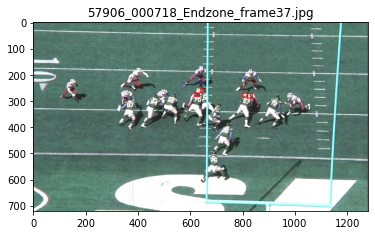

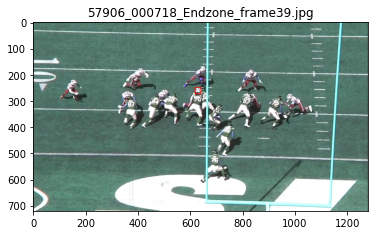

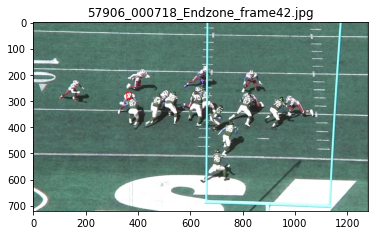

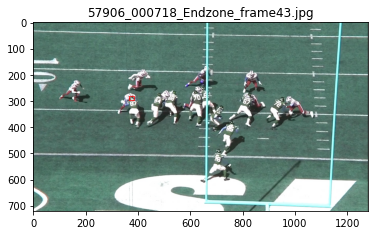

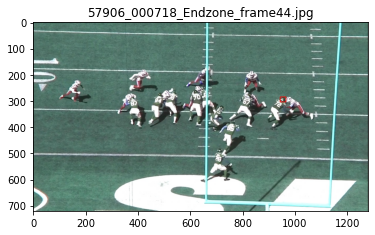

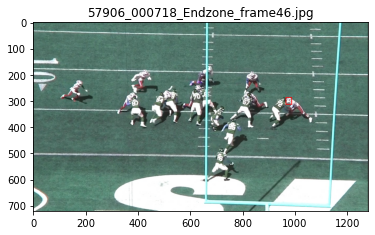

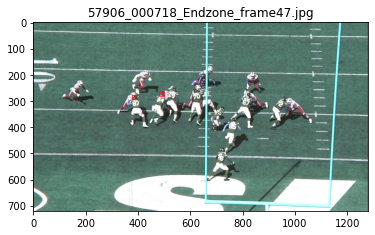

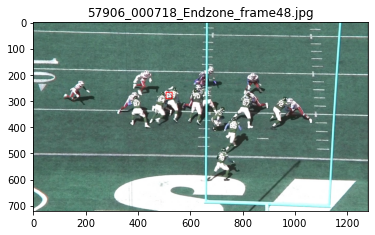

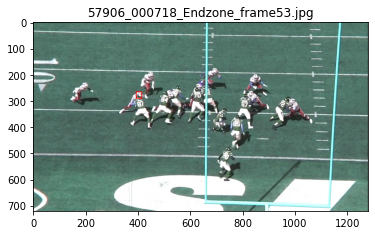

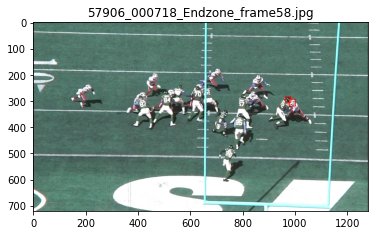

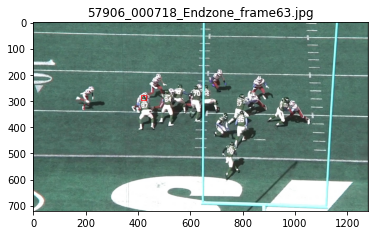

In [45]:
import matplotlib.pyplot as plt

for i, (image_name, preds) in enumerate(pred_data.groupby(['frame_name'])):
    img = cv2.imread('images/' + image_name) /255.

    img = add_bbox_to_image(img, preds[['left', 'top', 'right', 'down']].values.astype(int), np.ones_like(preds['down'].values))

    plt.imshow(img)
    plt.title(image_name)
    plt.show()
    if i == 10:
        break

In [46]:
pred_data = pred_data[["gameKey","playID","view","video","frame","left","width","top","height"]]
pred_data

,gameKey,playID,view,video,frame,left,width,top,height
520,57906,718,Endzone,57906_000718_Endzone.mp4,37,640.437530,19.374881,254.132457,16.648791
521,57906,718,Endzone,57906_000718_Endzone.mp4,37,617.733838,18.266167,269.535153,15.206288
522,57906,718,Endzone,57906_000718_Endzone.mp4,37,817.930134,20.453750,271.861320,18.511215
524,57906,718,Endzone,57906_000718_Endzone.mp4,37,801.216440,19.400877,270.548391,16.059931
232,57906,718,Endzone,57906_000718_Endzone.mp4,39,619.843242,21.497970,249.313501,23.871140
...,...,...,...,...,...,...,...,...,...
594,58102,2798,Sideline,58102_002798_Sideline.mp4,40,430.533591,17.263838,449.466368,10.736220
37,58102,2798,Sideline,58102_002798_Sideline.mp4,48,395.590019,18.819972,339.584874,21.413020
38,58102,2798,Sideline,58102_002798_Sideline.mp4,48,414.537149,16.877902,341.752281,20.082414
392,58102,2798,Sideline,58102_002798_Sideline.mp4,52,382.151620,18.054198,395.794140,24.564053


In [47]:
# clearing working dir
# be careful when running this code on local environment!
!rm -rf images/*
#!mv * /tmp/

In [48]:
import nflimpact
env = nflimpact.make_env()
env.predict(pred_data) # df is a pandas dataframe of your entire submission file